<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/LISAsprint_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/nbia-gwastro/binlite.git

Cloning into 'binlite'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 152 (delta 81), reused 115 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 6.63 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [3]:
%cd binlite

/content/binlite


In [5]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import Colormap
from matplotlib.ticker import FormatStrFormatter, NullFormatter, MultipleLocator, MaxNLocator,ScalarFormatter

import numpy as np

import astropy.constants as consts
import astropy.units as u
#import scipy.constants as consts
import random

from binlite import AccretionSeries, BinaryAlphaDisk
from binlite.flux import periodic_flux_series, normalized_flux_series, time_from_bad, normalized_flux_series_from_bad


In [6]:
# Make the code hardware agnostic.
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

# Making code agnostic to CPU/GPU
def std_get_wrapper(arg):
    return arg

def cuda_get_wrapper(arg):
    return arg.get()

if torch.cuda.is_available():
   import cupy as cp
   gpu = True
   get_wrapper = cuda_get_wrapper
   dev = "cuda:0"
   dtype = torch.cuda.FloatTensor
else:
   import numpy as cp
   gpu = False
   get_wrapper = std_get_wrapper
   dev = "cpu"
   dtype = torch.FloatTensor

print(gpu)

False


# Prepare training and validation data

In [221]:
################################################################################
# Code from Scott
################################################################################

# It seems binlite uses 1000 points per orbit.

# these parameters does not matter when we normalize the flux;
fedd = 0.1
dl_pc = 1.5 * 1e9   #
obs_nu = 2.4e17     # 1 keV  in Hz

#n_lcurves = int(1e4)
n_lcurves = int(2000)   # number of light curves

t_lisa = 10.*u.yr                  # full science period of LISA
#t_em_obs = 1.e6*u.s  # length of observation
t_em_obs = 80.e3*u.s  # length of observation
t_cadence = 1.e2*u.s  # spacing between data points
n_times = int( t_em_obs / t_cadence )

min_sep = 20.    # minimum separatin in r_g to consider
max_sep = 2000.  # minimum separatin in r_g to consider

lightcurves = np.ndarray((n_lcurves, n_times))

GMc2 = consts.GM_sun.cgs / consts.c.cgs**2

m_msun_pow = np.random.uniform(5.,7.,n_lcurves)
m_msuns = 10.**m_msun_pow
#sampling_parameters = m_msuns
r_g = m_msuns * GMc2

#obs_nu = vband_nu

freq_range = [1e-4,1e-1]/u.s
sep_min = (np.pi * freq_range[1] / (np.sqrt(consts.GM_sun.cgs * m_msuns)) )**(-2./3.)
sep_max = (np.pi * freq_range[0] / (np.sqrt(consts.GM_sun.cgs * m_msuns)) )**(-2./3.)
loc = (sep_min/r_g < min_sep)
sep_min[loc] = min_sep*r_g[loc]
loc = (sep_max/r_g > max_sep)
sep_max[loc] = max_sep*r_g[loc]

nbad = np.sum( sep_min > sep_max )

separation_pow = random.uniform(np.log10(sep_min[:]/r_g[:]),np.log10(sep_max[:]/r_g[:]))
separation = (10.**separation_pow) * r_g
period = (2.*np.pi*separation.cgs*np.sqrt(separation.cgs / (consts.GM_sun.cgs*m_msuns)))
sampling_parameters = period
print(f"period = {period}")
print(f"t_em_obs = {t_em_obs}")
freq = 1./period
p_yrs = (period / u.yr).cgs
n_orbits = ( (t_em_obs / period).cgs ).astype(int) + 1     # binlite requires an integer

eccs = np.random.uniform(0.0,0.8,n_lcurves)

print(f"n_orbits = {n_orbits}")
print(f"eccs     = {eccs}")
print(f"m_msuns  = {m_msuns}")
print(f"p_yrs    = {p_yrs}")

period = [23006.23837839  6674.28209124  6693.79888293 ...  1652.40916023
 17576.53340739 15846.42498522] s
t_em_obs = 80000.0 s
n_orbits = [ 4 12 12 ... 49  5  6]
eccs     = [0.33007319 0.37766685 0.77013918 ... 0.30207852 0.7430171  0.45758621]
m_msuns  = [8366547.7582277  2289273.30091714 2296284.49985739 ...  530576.95826147
 6311126.058541   5662098.99613431]
p_yrs    = [7.29023702e-04 2.11495237e-04 2.12113687e-04 ... 5.23616866e-05
 5.56966734e-04 5.02142906e-04]


In [222]:
for ecc, n_orb, m_msun, p_yr, ind in zip(eccs,n_orbits,m_msuns,p_yrs,np.arange(len(eccs),dtype=int)) :
    if ind % 100 == 0:
      print('ind : {:d}'.format(ind))
    #print('ecc : {:.2f}'.format(ecc))
    acc = AccretionSeries(ecc, n_modes=29, n_orbits=n_orb, retrograde=False)
    bad = BinaryAlphaDisk(ecc, p_yr, m_msun, dl_pc, eddington_ratio=fedd, retrograde=acc.is_retro)
    yrs = time_from_bad(acc, bad)
    flux = normalized_flux_series_from_bad(obs_nu, acc, bad)
    rednoise = 1.
    obsflux = flux * rednoise
    lightcurves[ind,:] = obsflux[0:n_times]

ind : 0


/content/binlite/binlite/flux.py:242: RuntimeWarning: overflow encountered in exp
  return 2. * hp_cgs * nu**3 / c_cgs**2 / (np.exp(exarg) - 1.0)


ind : 100
ind : 200
ind : 300
ind : 400
ind : 500
ind : 600
ind : 700
ind : 800
ind : 900
ind : 1000
ind : 1100
ind : 1200
ind : 1300
ind : 1400
ind : 1500
ind : 1600
ind : 1700
ind : 1800
ind : 1900


In [223]:
print(lightcurves.shape)

(2000, 800)


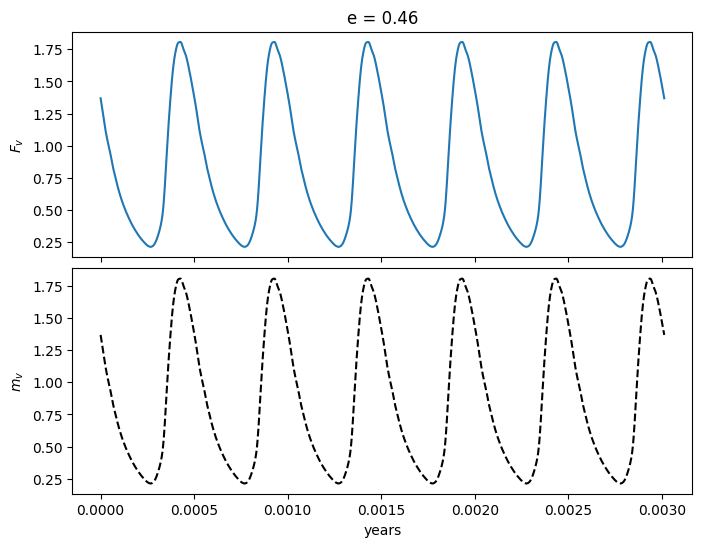

[1.36907291 1.36476413 1.36039164 ... 1.37750462 1.37331904 1.36907291]


In [225]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=[8, 6])
plt.subplots_adjust(hspace=0.05)
ax1.plot(yrs, flux, 'C0-')
ax2.plot(yrs, obsflux, 'k--')
#ax2.set_xlim([0.0, yrs[-1]])
#ax2.set_ylim([15.8, 14.2])
ax1.set_ylabel(r'$F_v$')
ax2.set_ylabel(r'$m_v$')
ax2.set_xlabel('years')
ax1.set_title(r'e = {:.2f}'.format(acc.ecc))
plt.show()
plt.close()
print(flux)

In [26]:
np.save('/content/drive/MyDrive/lightcurves.npy', lightcurves)

In [24]:
!ls

binlite  LICENSE.md  lightcurves.npy  MANIFEST.in  README.md  setup.py


In [27]:
print(sampling_parameters.shape)
np.save('/content/drive/MyDrive/sampling_parameters.npy', sampling_parameters)

(2000,)


In [251]:
# Package data to the Dataset

# For best training, parameters should be standardized (zero mean, unit variance across the training set).

parameters_mean = np.mean(sampling_parameters, axis=0)
parameters_std = np.std(sampling_parameters, axis=0)

parameters_standardized = (sampling_parameters - parameters_mean) / parameters_std
parameters_standardized = parameters_standardized.astype(np.float32)
print(parameters_standardized)


# Prepare the (complex) frequency-domain data for the (real) neural network. To do so we simply concatenate the real and imaginary parts into an array of doubled length.

lc_min = np.min(lightcurves, axis = 0)
lc_max = np.max(lightcurves, axis = 0)
print(lc_min.shape)

lc = 2*(lightcurves - lc_min)/(lc_max - lc_min) - 1.
print(lc.shape)

waveforms = np.expand_dims(lc, axis=1)
#waveforms = np.expand_dims(waveforms, axis=3)


print(waveforms.shape)
print(waveforms)


class WaveformDataset(Dataset):

    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]

        # Add unit normal noise to the signal
        # noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = signal

        return torch.tensor(data).type(dtype), torch.tensor(params).type(dtype)



[ 2.4588945   0.07989837  0.08274129 ... -0.6516133   1.667976
  1.4159596 ]
(800,)
(2000, 800)
(2000, 1, 800)
[[[-0.91166352 -0.91120851 -0.91086301 ... -0.86515538 -0.86879686
   -0.87267703]]

 [[ 0.30459669  0.30284026  0.30132996 ... -0.22476584 -0.21942572
   -0.21500452]]

 [[-0.69833465 -0.68946952 -0.68119226 ... -0.91797083 -0.92177205
   -0.92576587]]

 ...

 [[-0.88609982 -0.88550674 -0.88504026 ... -0.83951061 -0.84313831
   -0.84703581]]

 [[-0.43428714 -0.43124296 -0.42940918 ... -0.9022733  -0.90594731
   -0.90975996]]

 [[ 0.21305192  0.20979814  0.20668226 ...  0.78594502  0.78671296
    0.7850399 ]]]


In [252]:
# Define network

model = torch.nn.Sequential(
          nn.Conv1d(1,8,10,padding="same"), # [input channels, number of filters, filter size]
          nn.BatchNorm1d(8),
          nn.Tanh(),
          nn.MaxPool1d(2),
          nn.Conv1d(8,16,8,padding="same"),
          nn.Tanh(),
          nn.MaxPool1d(2),
          #nn.Conv1d(16,8,8,padding="same"),
          #nn.Tanh(),
          #nn.MaxPool1d(2),
          nn.Flatten(),
          nn.LazyLinear(128), # LazyLinear automatically computes the input size from flattened convolutions
          nn.Sigmoid(),
          nn.LazyLinear(64),
          nn.Sigmoid(),
          nn.LazyLinear(1)
        ).to(dev)



In [253]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

In [254]:
# Split the dataset into training and test sets. We use the test set to make sure the network properly generalizes to data that it has not seen in training, i.e., it does not overfit.
num_samples = n_lcurves
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training.

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) # batch_size=256
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [255]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data.

train_features, train_labels = next(iter(train_dataloader))

In [256]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=5e-4)

In [257]:
# We use Meas Square Error.
loss_func = torch.nn.MSELoss()


In [258]:
# Training and test loops.

def train_loop(dataloader, model, optimizer):

    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        outputs = model(X)
        loss = loss_func(outputs, y)

        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")

    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss


In [259]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            loss = loss_func(outputs, y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss



In [260]:

epochs = 30
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss.cpu())
print("Done!")

Epoch 1
-------------------------------
Loss: 1.132559  [    0/ 1600 samples]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Average loss: 0.0080
Test loss: 0.009926 

Epoch 2
-------------------------------
Loss: 1.294274  [    0/ 1600 samples]
Average loss: 0.0081
Test loss: 0.009914 

Epoch 3
-------------------------------
Loss: 0.892733  [    0/ 1600 samples]
Average loss: 0.0082
Test loss: 0.009907 

Epoch 4
-------------------------------
Loss: 1.150574  [    0/ 1600 samples]
Average loss: 0.0082
Test loss: 0.009915 

Epoch 5
-------------------------------
Loss: 1.305635  [    0/ 1600 samples]
Average loss: 0.0082
Test loss: 0.009913 

Epoch 6
-------------------------------
Loss: 0.916706  [    0/ 1600 samples]
Average loss: 0.0082
Test loss: 0.009907 

Epoch 7
-------------------------------
Loss: 0.879217  [    0/ 1600 samples]
Average loss: 0.0081
Test loss: 0.009917 

Epoch 8
-------------------------------
Loss: 0.642920  [    0/ 1600 samples]
Average loss: 0.0082
Test loss: 0.009911 

Epoch 9
-------------------------------
Loss: 1.004225  [    0/ 1600 samples]
Average loss: 0.0081
Test loss: 

<class 'list'>


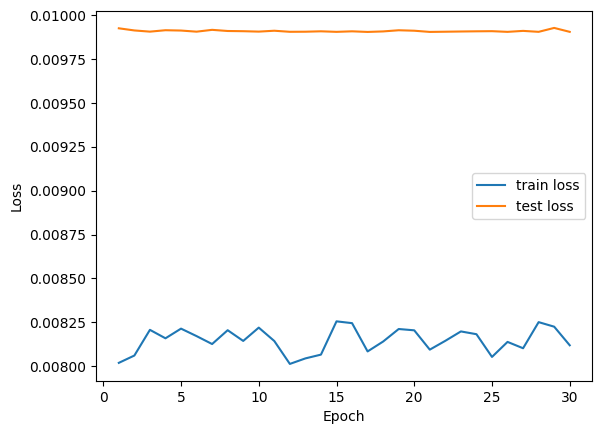

In [261]:
epochs = np.arange(1, len(train_history) + 1)
print(type(test_history))
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [262]:


test_features, test_labels = next(iter(test_dataloader))
test_outputs = model(test_features)




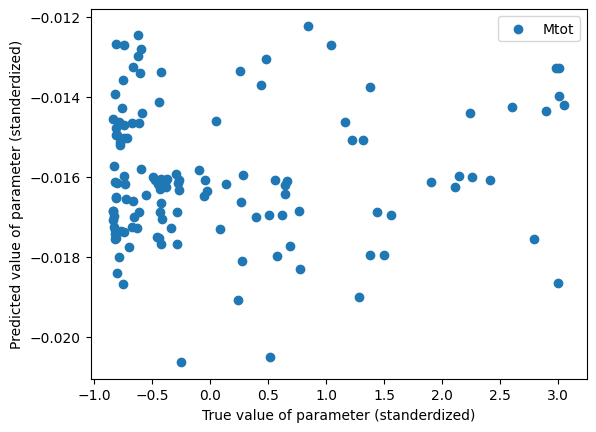

In [263]:
plt.scatter(test_labels[:], test_outputs[:].detach().numpy(), label = 'Mtot')
#plt.scatter(test_labels[:,1], test_outputs[:,1].detach().numpy(), label = 'amplitude')
plt.xlabel('True value of parameter (standerdized)')
plt.ylabel('Predicted value of parameter (standerdized)')
plt.legend()
plt.show()